## Hotel Cancellations: Analysis & Prediction

The goal of this notebook is to perform exploratory analysis in order to answer the business questions related to the data for the city and resort hotels, as well as compare the performance of three models to predict if a reservation will be cancelled.

## Preamble

We import the needed libraries and configurations.

In [ ]:
# data wrangling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras import backend as K

# miscellaneous
import pycountry
import os
import missingno as msno
import warnings
warnings.simplefilter("ignore")

In [ ]:
base_dir = '/data/'
file_name = 'Hotel.csv'

file_dir = os.path.join(base_dir,file_name)

if os.path.exists(file_dir):
  df = pd.read_csv(file_dir)
  print('File loaded succesfully!')
  if df.empty:
    print('Dataframe empty. Please verify file integrity.')
else:
  print('Failed to load file. Please verify file location.')

## I. Data Cleaning

We start by performing an exploratory analysis of the data, verifying data integrity. We check for statistics and clean data of any outliers or missing values.

In [ ]:
# show head of data
df.head(5)

,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,1,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
1,2,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
2,3,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2/7/2015
3,4,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2/7/2015
4,5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,3/7/2015


In [ ]:
# show tail of data
df.tail(5)

,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
119385,119386,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,6/9/2017
119386,119387,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,7/9/2017
119387,119388,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,7/9/2017
119388,119389,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,7/9/2017
119389,119390,City Hotel,0,205,2017,August,35,29,2,7,2,0.0,0,HB,DEU,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,151.20,0,2,Check-Out,7/9/2017


In [ ]:
# dataframe dimensions
df.shape

(119390, 33)

We have a total of 33 columsn and 119,390 registries.

In [ ]:
# dates for the table
df.groupby(['arrival_date_year','arrival_date_month'])['id'].count()

arrival_date_year  arrival_date_month
2015               August                3889
                   December              2920
                   July                  2776
                   November              2340
                   October               4957
                   September             5114
2016               April                 5428
                   August                5063
                   December              3860
                   February              3891
                   January               2248
                   July                  4572
                   June                  5292
                   March                 4824
                   May                   5478
                   November              4454
                   October               6203
                   September             5394
2017               April                 5661
                   August                4925
                   February              4

Data ranges from July 2015 to August 2017.

**Missing values**

In [ ]:
# check for data types per column
df.dtypes

id                                  int64
hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                      

We have both numerical and categorical values.

In [ ]:
# check columns with missing values.
for col in df.columns:
  if df[col].isnull().values.any():
    print({'Columnas con nulos' : col, 'Porcentaje de nulos' : round(df[col].isnull().sum()/df.shape[0]*100,1)})

{'Columnas con nulos': 'children', 'Porcentaje de nulos': 0.0}
{'Columnas con nulos': 'country', 'Porcentaje de nulos': 0.4}
{'Columnas con nulos': 'agent', 'Porcentaje de nulos': 13.7}
{'Columnas con nulos': 'company', 'Porcentaje de nulos': 94.3}


We can get a better visualization of missing values with the MissingNo library.

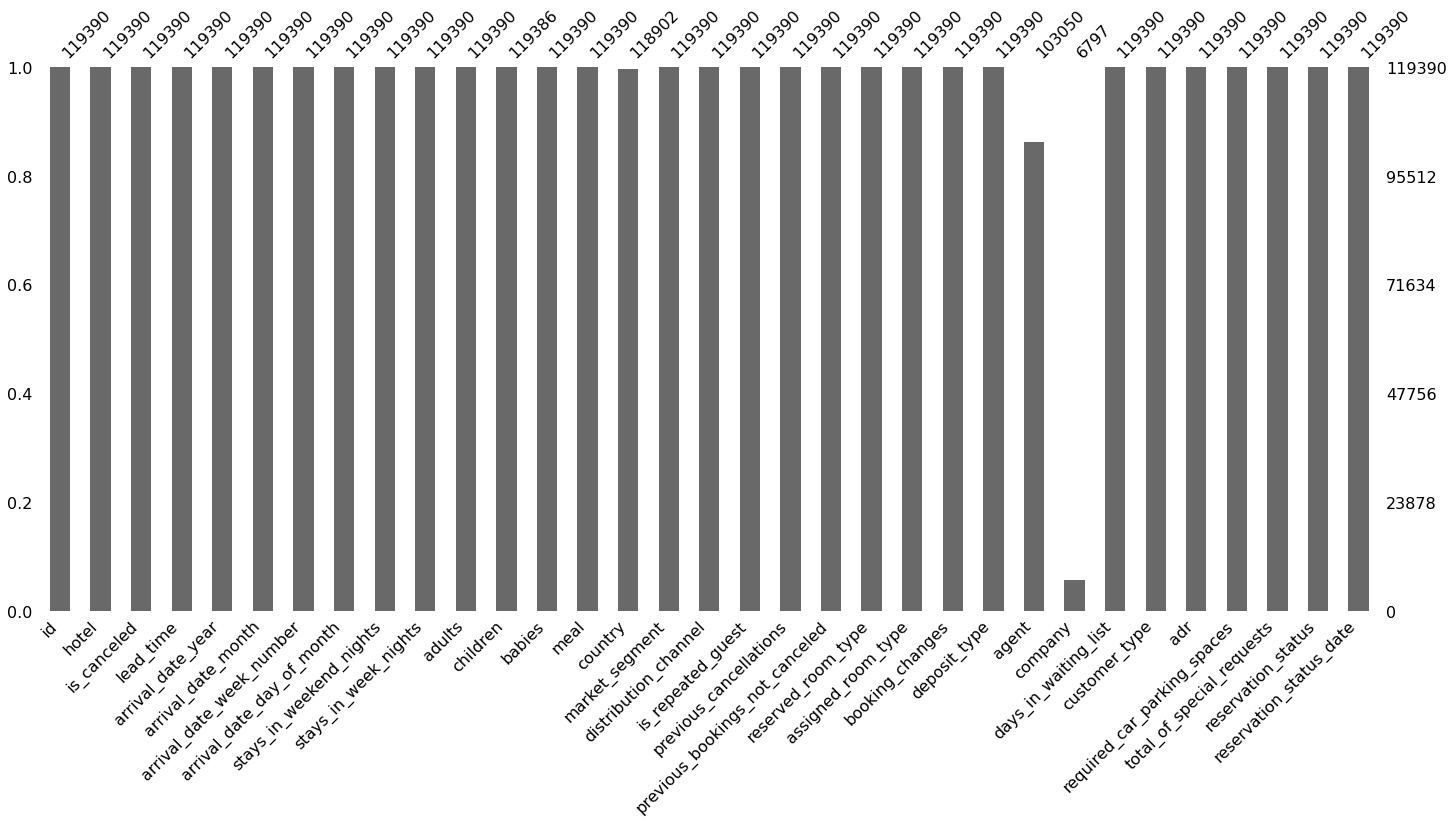

In [ ]:
# percentage of missing values in bar plot
msno.bar(df)

The columns 'children', 'country', 'agent' and 'company' are the only ones that have missing data. Moreover, for the case of 'company' almost all values are missing, so it is best to drop it.

We can check some examples to have a better idea of the cause of missing data.

In [ ]:
df[pd.isnull(df['children'])].head(2)

,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
40600,40601,City Hotel,1,2,2015,August,32,3,1,0,2,NaN,0,BB,PRT,Undefined,Undefined,0,0,0,B,B,0,No Deposit,NaN,NaN,0,Transient-Party,12.0,0,1,Canceled,1/8/2015
40667,40668,City Hotel,1,1,2015,August,32,5,0,2,2,NaN,0,BB,PRT,Direct,Undefined,0,0,0,B,B,0,No Deposit,14.0,NaN,0,Transient-Party,12.0,0,1,Canceled,4/8/2015


In [ ]:
df[pd.isnull(df['agent'])].head(2)

,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,1,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
1,2,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015


Since we are dealing with hotel reservations, the explanation of why we have missing data in these columns is as follows:

* 'children': not all people who book have children, so it is very likely that at the time of booking they simply left this field empty. Therefore, we can replace null values with 0.
* country': in this case we are dealing with people who did not specify their country of origin. Since countries are categorical data, we can replace null values by UNKNOWN.
* agent': in this case these are people who did not book through an agency, i.e. they booked their hotel directly. Since agents are identified numerically, we can replace null values by 0 (equivalent to 'no agent').
* company': in this case we are dealing with people who do not belong to any company. Since most of the data is missing, we drop this column all together.

In [ ]:
# replace NaN in column 'children'
df['children'] = df['children'].fillna(0)

# replace NaN in column 'country'
df['country'] = df['country'].replace(np.nan,'UNKNOWN')

# replace NaN in column 'agent'
df['agent'] = df['agent'].fillna(0)

# drop column 'company'
df.drop('company', axis=1, inplace=True)

# reset indices
df.reset_index(inplace=True)

df.head(5)

,index,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,1,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0,Transient,0.0,0,0,Check-Out,1/7/2015
1,1,2,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0,Transient,0.0,0,0,Check-Out,1/7/2015
2,2,3,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0,Transient,75.0,0,0,Check-Out,2/7/2015
3,3,4,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2/7/2015
4,4,5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,3/7/2015


In [ ]:
# check again for missing values
df.isnull().values.any()

False

**Dealing with outliers**

Let's check the statistics for the numerical columns of the dataset.

In [ ]:
# general statistics of dataframe
df.describe()

,index,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,59694.500000,59695.500000,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103886,0.007949,0.031912,0.087118,0.137097,0.221124,74.828319,2.321149,101.831122,0.062518,0.571363
std,34465.068657,34465.068657,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398555,0.097436,0.175767,0.844336,1.497437,0.652306,107.141953,17.594721,50.535790,0.245291,0.792798
min,0.000000,1.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,29847.250000,29848.250000,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,69.290000,0.000000,0.000000
50%,59694.500000,59695.500000,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,94.575000,0.000000,0.000000
75%,89541.750000,89542.750000,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,152.000000,0.000000,126.000000,0.000000,1.000000
max,119389.000000,119390.000000,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,391.000000,5400.000000,8.000000,5.000000


We can see that we have ouliers, such as '737' in lead_time. These are usually generated by errors when entering or copying data, or they can be completely natural and random events. We usually want to eliminate these types of values, as they can introduce a lot of variance into our predictive model. However, it is also important to mention that they can be a source of relevant information to understand unusual behaviors given a situation.

Therefore, before making a decision, it is convenient that we analyze a little better the distribution of such outliers.

We identify the presence of outliers in the following columns:

* lead_time
* stays_in_weekend_nights
* stays_in_week_nights
* adults
* children
* babies
* previous_cancellations
* previous_bookings_not_canceled
* booking_changes
* days_in_waiting_list
* adr

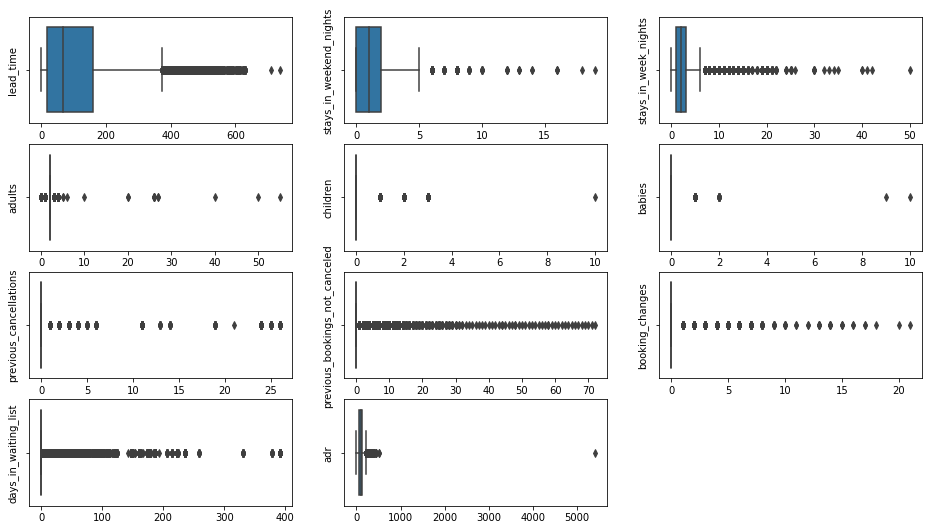

In [ ]:
# define list of columns with ouliers
out_cols = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults',
            'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
            'booking_changes', 'days_in_waiting_list', 'adr']

plt.figure(figsize=(16,9))

# plot boxplots in groups
for i, col in enumerate(out_cols):
  plt.subplot(4,3,i+1)
  sns.boxplot(df[col])
  plt.xlabel('')
  plt.ylabel(col)

We are interested in knowing the percentage of extreme values that exceed the mean, i.e., that are above the quantile plus 1.5 times the interquantile range, since these are the cases that can most affect a potential client's reservation and stay.

In [ ]:
# percentage of outliers (only above IQR)
for col in out_cols:
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  print(col, round(((df[col] > (q3+1.5*iqr))).sum() / df.shape[0]*100,1))

lead_time 2.5
stays_in_weekend_nights 0.2
stays_in_week_nights 2.8
adults 5.3
children 7.2
babies 0.8
previous_cancellations 5.4
previous_bookings_not_canceled 3.0
booking_changes 15.1
days_in_waiting_list 3.1
adr 3.2


We can observe the following:

* In most cases, the percentage of extreme (top) values is relatively small compared to the size of the dataset (less than 5%), although they can still provide relevant information about customers with reservations that have parameters outside the average. This could be useful for a hotel so it can consider *edge cases* in its operation.

* On the other hand, the *booking_changes* column has the highest number of extreme values, reaching even more than 20. This can be explained by the presence of people who make many changes in preparation for their trip, or people who are just exploring accommodation options and want to have a reservation ready for any situation.

* For the moment we will not remove the outliers, as they may be part of the insights derived in the exploratory analysis, but we will come back to them when we move to the predictive model section.

**Reservations without guests**

Before moving forward, it is convenient to check some details on the consistency of the data.

All rows must have a non-zero number of guests, i.e., the sum of adults + children + infants must be non-zero. Otherwise, it would not make sense to have a reservation for zero people.

In [ ]:
# check for reservations with zero guests
zero_check = (df['adults'] == 0) & (df['children' ] == 0) & (df['babies'] == 0)
df['id'][zero_check].count()

In [ ]:
# display rows with zero guests in reservations
df[zero_check].head(3)

,index,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
2224,2224,2225,Resort Hotel,0,1,2015,October,41,6,0,3,0,0.0,0,SC,PRT,Corporate,Corporate,0,0,0,A,I,1,No Deposit,0.0,0,Transient-Party,0.0,0,0,Check-Out,6/10/2015
2409,2409,2410,Resort Hotel,0,0,2015,October,42,12,0,0,0,0.0,0,SC,PRT,Corporate,Corporate,0,0,0,A,I,0,No Deposit,0.0,0,Transient,0.0,0,0,Check-Out,12/10/2015
3181,3181,3182,Resort Hotel,0,36,2015,November,47,20,1,2,0,0.0,0,SC,ESP,Groups,TA/TO,0,0,0,A,C,0,No Deposit,38.0,0,Transient-Party,0.0,0,0,Check-Out,23/11/2015


We see that about 180 reservations have no people assigned to them. Since this represents only 0.15% of the total, we can delete them without major alterations on our analysis and modeling.

In [ ]:
# drop rows with zero guests
df = df[~zero_check]
df.reset_index(inplace=True)

df.head(5)

,level_0,index,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,0,1,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0,Transient,0.0,0,0,Check-Out,1/7/2015
1,1,1,2,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0,Transient,0.0,0,0,Check-Out,1/7/2015
2,2,2,3,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0,Transient,75.0,0,0,Check-Out,2/7/2015
3,3,3,4,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2/7/2015
4,4,4,5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,3/7/2015


## II. Exploratory Analysis

Once the data cleaning and preparation is complete, we can proceed with the exploratory analysis. In particular, we will focus on answering the questions posed at the start.

In [ ]:
df.head(3)

,level_0,index,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,0,1,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0,Transient,0.0,0,0,Check-Out,1/7/2015
1,1,1,2,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0,Transient,0.0,0,0,Check-Out,1/7/2015
2,2,2,3,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0,Transient,75.0,0,0,Check-Out,2/7/2015


**Where do guests come from?**

We are interested in knowing from which countries the guests come from, so we consider only those who did not cancel their reservation.

In [ ]:
# list of unique countries
countries = (df['country'][df['is_canceled'] == 0].value_counts()).to_frame()
countries.reset_index(inplace=True)
countries.columns = ['Country (ISO)', 'No. guests']
countries.head(5)

,Pais (ISO),No. huespedes
0,PRT,20977
1,GBR,9668
2,FRA,8468
3,ESP,6383
4,DEU,6067


The countries are coded in their ISO acronyms. To simplify the reading, we converted them to their common names and ordered them according to the number of guests per country.

In [ ]:
# delete values for 'UNKNOWN'
countries.drop(countries[countries['Country (ISO)'] == 'UNKNOWN'].index[0],axis=0,inplace=True)

# correct code for China
countries.replace('CN', 'CHN',inplace=True)

In [ ]:
# create column for country name
countries['Country'] = ''

# convert ISO codes to country names
for i, c in enumerate(list(countries['Pais (ISO)'])):
  if c != 'TMP': # the library does not recognize TMP as East Timor
    countries['Country'].iloc[i] = pycountry.countries.get(alpha_3=c).name
  else:
   countries['Country'].iloc[i] = 'East Timor' # manually added

countries.head(10)

,Pais (ISO),No. huespedes,Pais
0,PRT,20977,Portugal
1,GBR,9668,United Kingdom
2,FRA,8468,France
3,ESP,6383,Spain
4,DEU,6067,Germany
5,IRL,2542,Ireland
6,ITA,2428,Italy
7,BEL,1868,Belgium
8,NLD,1716,Netherlands
9,USA,1592,United States


We note that we have visitors from various countries around the world. The ten countries from which most of the guests originate are: Portugal, United Kingdom, France, Spain, Germany, Ireland, Italy, Belgium, Netherlands and the United States. Since both hotels are in Portugal, it is no surprise that the majority of guests do indeed originate from Portugal.

Another way to visualize the origin of hotel guests is by using of a global map with Cloropleth.

In [ ]:
# we create an interactive map with Cloropleth
fig = px.choropleth(countries, locations='Country (ISO)',
                    color='No. guests',
                    hover_name='Country',
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()

**How much do guests pay for a room per night on average?**

The cost per night for each hotel is given in the column 'adr' (*average daily rate*). Since the hotel is located in Portugal, we assume that the prices given are in euros.

In [ ]:
# average cost per night (city hotel)
print('Average cost per night (city hotel): ', round(df[df['is_canceled'] == 0]['adr'][df['hotel']=='City Hotel'].mean(),2), 'EUR')

# average cost per night (resort hotel)
print('Average cost per night (resort hotel): ', round(df[df['is_canceled'] == 0]['adr'][df['hotel']=='Resort Hotel'].mean(),2), 'EUR')

Costo promedio por noche (hotel urbano):  106.04 EUR
Costo promedio por noche (hotel resort):  90.82 EUR


We see that guests pay ~106 EUR/night for the city hotel, and ~91 EUR/night for the resort hotel. However, it is clear that the price per night will depend on the type of room and the services included (e.g. meals). It would be interesting to check if there is any variation depending on the room type.

In [ ]:
# room types in city hotel
urban_price = (df[df['hotel']=='City Hotel'].groupby('reserved_room_type')['adr'].mean()).to_frame()
urban_price['std'] = df[df['hotel']=='City Hotel'].groupby('reserved_room_type')['adr'].std()

# room types in resort hotel
resort_price = (df[df['hotel']=='Resort Hotel'].groupby('reserved_room_type')['adr'].mean()).to_frame()
resort_price['std'] = df[df['hotel']=='Resort Hotel'].groupby('reserved_room_type')['adr'].std()


hotel_price = urban_price.merge(resort_price, on='reserved_room_type', how='outer')
hotel_price.index.names = ['Room type']
hotel_price.columns = ['Cost (City)', '+/- (City)', 'Cost (Resort)', '+/- (Resort)']

print('====Cost per night per hotel====')

hotel_price

====Costos por noche por hotel====


,Costo (Urbano),+/- (Urbano),Costo (Resort),+/- (Resort)
Tipo habitacion,,,,
A,96.401704,37.153354,76.243044,48.887214
B,90.515027,34.359555,104.666667,32.331615
C,92.057692,54.982209,161.356536,71.125665
D,131.679145,36.153763,103.628341,58.048494
E,158.143162,48.507953,114.485054,59.142521
F,189.576689,46.985461,132.761121,70.374286
G,202.637842,88.021282,168.238658,74.819953
H,NaN,NaN,188.223111,75.893064
L,NaN,NaN,124.666667,69.451182


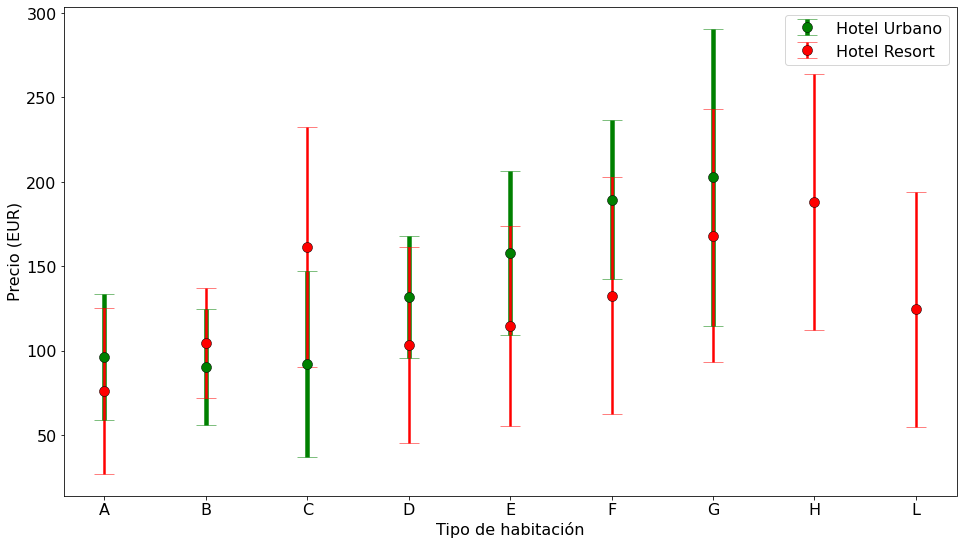

In [ ]:
plt.figure(figsize=(16,9))

# plot average price of city hotel (plus standard deviation)
plt.errorbar(urban_price.index, urban_price['adr'],yerr=urban_price['std'], fmt='o', marker='o',
             markersize=10,markeredgewidth=0.5,markeredgecolor='black',
             elinewidth=4.5,capsize=10,color='green',label='Hotel Urbano')


# plot average price of resort hotel (plus standard deviation)
plt.errorbar(resort_price.index, resort_price['adr'], yerr=resort_price['std'], fmt='o', marker='o',
             markersize=10,markeredgewidth=0.5,markeredgecolor='black',
             elinewidth=2.5,capsize=10,color='red',label='Hotel Resort')

for t in plt.xticks()[1]:
    t.set_fontsize(16)

for t in plt.yticks()[1]:
    t.set_fontsize(16)

plt.xlabel('Tipo de habitación', fontsize=16)
plt.ylabel('Precio (EUR)',  fontsize=16)
plt.legend(fontsize=16)

Indeed, we see that prices depend on the type of room and the type of hotel. For example, a room type A costs on average more in the city hotel, but a room type C costs on average more in the resort hotel.

**How does the price per night change during the year?**

We had seen that we have data for 2015, 2016 and 2017. Therefore, since what we are interested in is the average prices per night during the year, we will take the average of those three years for each month.

Note: we could also group them by day or by week, but months were chosen since it is generally much easier to visualize the variation of annual behaviors on this scale.

In [ ]:
# months list
months_eng = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'Octuber', 'November', 'December']

# costo de noche por año para hotel urbano
urban_monthly = (df[df['is_canceled'] == 0][df['hotel'] == 'City Hotel'].groupby('arrival_date_month')['adr'].mean()).to_frame()
urban_monthly.columns = ['Costo/noche']

# ordenar por mes
urban_monthly['Month'] = pd.to_datetime(urban_monthly.index, format='%B').month
urban_monthly = urban_monthly.sort_values(by='Mes').drop('Mes',axis=1)
urban_monthly.index = months_eng
urban_monthly.index.names = ['Month']

# costo de noche por año para hotel resort
resort_monthly = (df[df['is_canceled'] == 0][df['hotel'] == 'Resort Hotel'].groupby('arrival_date_month')['adr'].mean()).to_frame()
resort_monthly.columns = ['Price/night']

# ordenar por mes
resort_monthly['Mes'] = pd.to_datetime(resort_monthly.index, format='%B').month
resort_monthly = resort_monthly.sort_values(by='Mes').drop('Mes',axis=1)
resort_monthly.index = months_esp
resort_monthly.index.names = ['Month']

# combinar dataframes
hotel_monthly = urban_monthly.merge(resort_monthly, on='Mes')
hotel_monthly.columns = ['Price/night (City Hotel)', 'Price/night (Resort Hotel)']
hotel_monthly

,Precio/noche (Hotel Urbano),Precio/noche (Hotel Resort)
Mes,,
Enero,82.330983,48.761125
Febrero,86.520062,54.147478
Marzo,90.658533,57.056838
Abril,111.962267,75.867816
Mayo,120.669827,76.657558
Junio,117.874360,107.974850
Julio,115.818019,150.122528
Agosto,118.674598,181.205892
Septiembre,112.776582,96.416860


<Figure size 1152x648 with 0 Axes>

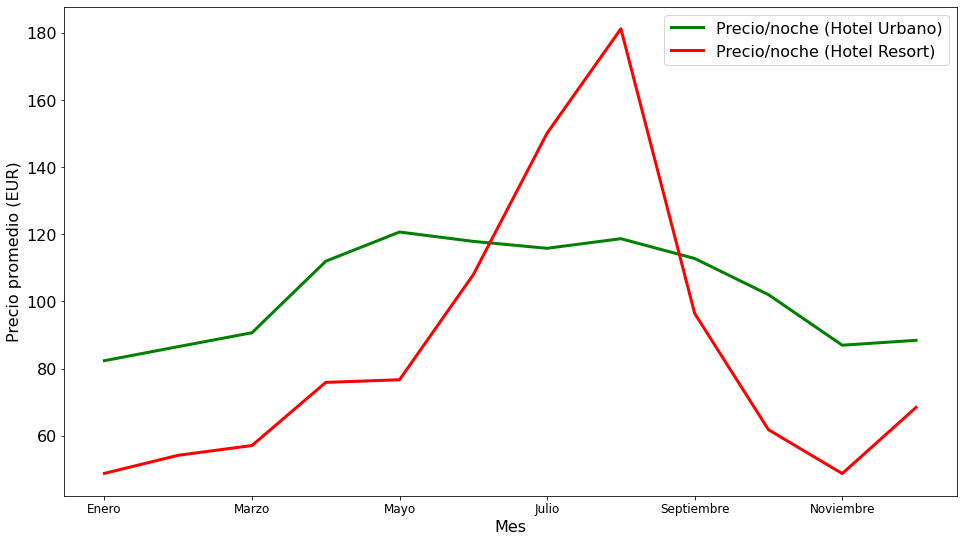

In [ ]:
plt.figure(figsize=(16,9))

# plot monthly price per hotel
hotel_monthly.plot.line(linewidth=3.0, color=['green', 'red'], figsize=(16,9))

for t in plt.xticks()[1]:
    t.set_fontsize(12)

for t in plt.yticks()[1]:
    t.set_fontsize(16)

plt.xlabel('Mes', fontsize=16)
plt.ylabel('Precio promedio (EUR)',  fontsize=16)
plt.legend(fontsize=16)

We observe that the city hotel has a relatively stable price between the months of April and September (spring-summer), and lowers its cost between November and February (winter).

On the other hand, the resort hotel increases its prices significantly between the months of June and September (summer-autumn), while it has its lowest prices between November and March (winter). It is possible that this is due to changes in demand due to the summer and winter vacation periods.

**Which are the busiest months?**

While it is true that each reservation may have a different number of people, each reservation corresponds to a single room. Since a hotel is interested in the number of occupied rooms, we count the number of reservations (not cancelled) per hotel and per month (again we take the average of the three years).

In [ ]:
# monthly occupancy for city hotel
urban_busy = (df[df['is_canceled'] == 0][df['hotel'] == 'City Hotel'].groupby('arrival_date_month')['arrival_date_year'].
              value_counts().groupby('arrival_date_month').mean()).to_frame()
urban_busy.columns = ['Ocupacion']

# sort by month
urban_busy['Month'] = pd.to_datetime(urban_busy.index, format='%B').month
urban_busy = urban_busy.sort_values(by='Mes').drop('Mes',axis=1)
urban_busy.index = months_esp
urban_busy.index.names = ['Month']

# monthly occupancy for resort hotel
resort_busy = (df[df['is_canceled'] == 0][df['hotel'] == 'Resort Hotel'].groupby('arrival_date_month')['arrival_date_year'].
              value_counts().groupby('arrival_date_month').mean()).to_frame()
resort_busy.columns = ['Ocupacion']

# sort by month
resort_busy['Month'] = pd.to_datetime(resort_busy.index, format='%B').month
resort_busy = resort_busy.sort_values(by='Mes').drop('Mes',axis=1)
resort_busy.index = months_esp
resort_busy.index.names = ['Mes']

# combinar dataframes
hotel_busy = urban_busy.merge(resort_busy, on='Mes')
hotel_busy.columns = ['Ocupacion (Hotel Urbano)', 'Ocupacion (Hotel Resort)']
hotel_busy

,Ocupacion (Hotel Urbano),Ocupacion (Hotel Resort)
Mes,,
Enero,1124.5,933.000000
Febrero,1525.5,1154.000000
Marzo,2024.5,1285.500000
Abril,2005.0,1275.000000
Mayo,2284.0,1267.500000
Junio,2179.0,1018.500000
Julio,1590.0,1045.666667
Agosto,1789.0,1085.666667
Septiembre,2141.5,1051.000000


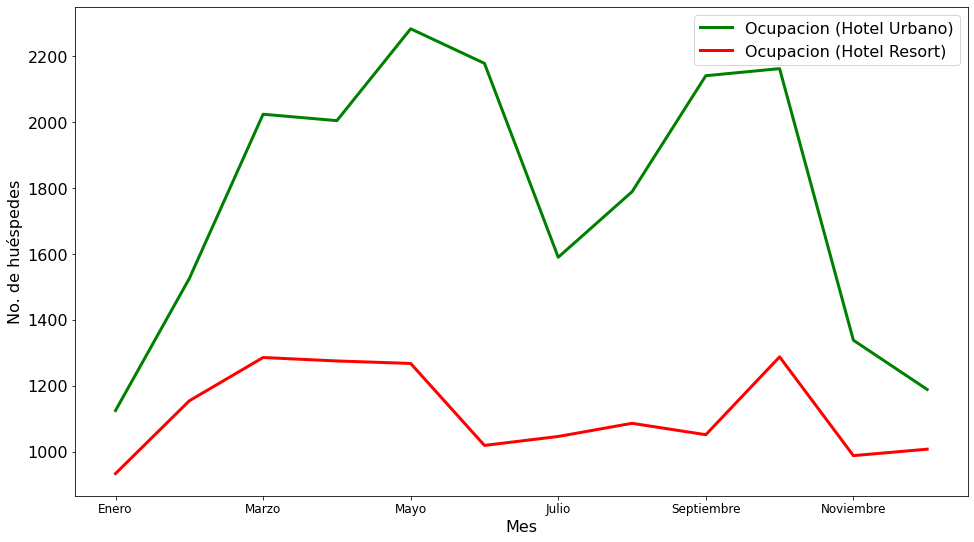

In [ ]:
# graficar no. de huespedes por hotel
hotel_busy.plot.line(linewidth=3.0, color=['green', 'red'], figsize=(16,9))

for t in plt.xticks()[1]: # cambiar tamaño de ticks horizontales
    t.set_fontsize(12)

for t in plt.yticks()[1]: # cambiar tamaño de ticks verticales
    t.set_fontsize(16)

plt.xlabel('Mes', fontsize=16)
plt.ylabel('No. de huéspedes',  fontsize=16)
plt.legend(fontsize=16)

We observe that city hotel occupancy is the one that fluctuates the most during the year, reaching high occupancy rates between the months of March and May as well as between September and October. On the other hand, the lowest occupancy is recorded between December and February (winter), which compared to the price graph also corresponds to the months with the lowest rates per night. A drop in occupancy is also observed in July, perhaps due to the end of the holiday season.

On the other hand, the resort hotel has a lower occupancy compared to the city hotel, and reaches a higher occupancy between the months of March and May as well as during the month of October. On the other hand, occupancy decreases between the months of June and September, which, compared to the price graph, corresponds to the months with the highest rate per night. Likewise, comparably low occupancy is recorded between December and January.

**How many nights do guests stay in each hotel?**

To know the total length of stay we simply take the number of weekday nights plus the number of weekend nights. We start by analyzing the average number of nights per hotel.

In [ ]:
# add column for total stay nights
df['stays_nights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

df[df['is_canceled'] == 0]['stays_in_weekend_nights'].unique()

array([ 0,  1,  2,  4,  3, 13,  6,  8,  5,  7, 12, 18, 19,  9, 10, 16, 14])

It is interesting to note that there are reservations where people did stay but stayed zero nights. It is possible that this is because they were people who temporarily stayed in a room and checked out on the same day.

In [ ]:
# average nights for city hotel
print('Average stay (city hotel): ', round(df[df['is_canceled'] == 0][df['hotel'] == 'City Hotel']['stays_nights'].mean(),1), ' night')

# average nights for resort hotel
print('Average stay (resort hotel): ', round(df[df['is_canceled'] == 0][df['hotel'] == 'Resort Hotel']['stays_nights'].mean(),1), ' night')

Estancia promedio (hotel urbano):  2.9  noches
Estancia promedio (hotel resort):  4.1  noches


In [ ]:
# length of stay per month (city hotel)
urban_nights = (round(df[df['is_canceled'] == 0][df['hotel'] == 'City Hotel'].groupby('arrival_date_month')['stays_nights'].mean(),1)).to_frame()
urban_nights.columns = ['No. Nights']

# sort by month
urban_nights['Mes'] = pd.to_datetime(urban_nights.index, format='%B').month
urban_nights = urban_nights.sort_values(by='Month').drop('Mes',axis=1)
urban_nights.index = months_esp
urban_nights.index.names = ['Month']

# length of stay per month (resort hotel)
resort_nights = (round(df[df['is_canceled'] == 0][df['hotel'] == 'Resort Hotel'].groupby('arrival_date_month')['stays_nights'].mean(),1)).to_frame()
resort_nights.columns = ['No. nights']

# sort by month
resort_nights['Month'] = pd.to_datetime(resort_nights.index, format='%B').month
resort_nights = resort_nights.sort_values(by='Month').drop('Mes',axis=1)
resort_nights.index = months_esp
resort_nights.index.names = ['Month']

# combine dataframjes
hotel_nights = urban_nights.merge(resort_nights, on='Month')
hotel_nights.columns = ['Nights (City Hotel)', 'Nights (Resort Hotel)']
hotel_nights

,Noches (Hotel Urbano),Noches (Hotel Resort)
Mes,,
Enero,2.8,2.7
Febrero,2.9,3.0
Marzo,3.0,3.7
Abril,3.0,3.8
Mayo,2.8,4.2
Junio,2.8,5.3
Julio,3.1,5.2
Agosto,3.1,5.2
Septiembre,2.8,5.2


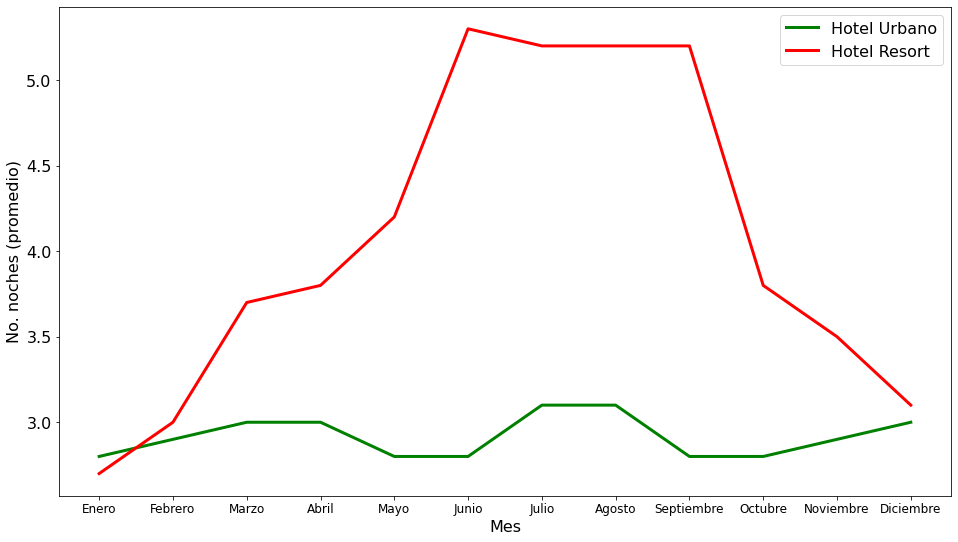

In [ ]:
plt.figure(figsize=(16,9))

# graficar noches promedio por mes para hotel urbano
plt.plot(hotel_nights.index, hotel_nights['Nights (City Hotel)'],
         linewidth = 3.0, color='green', label='City Hotel')

# graficar noches promedio por mes para hotel resort
plt.plot(hotel_nights.index, hotel_nights['Nights (Resort Hotel)'],
         linewidth = 3.0, color='red', label='Resort Hotel')

for t in plt.xticks()[1]: # cambiar tamaño de ticks horizontales
    t.set_fontsize(12)

for t in plt.yticks()[1]: # cambiar tamaño de ticks verticales
    t.set_fontsize(16)

plt.xlabel('Month', fontsize=16)
plt.ylabel('No. Nights (average)',  fontsize=16)
plt.legend(fontsize=16)

We can observe that in the case of the city hotel, people stay ~3 nights throughout the year, i.e., the length of stays are relatively constant. On the other hand, the length of stays at the resort hotel increases significantly to ~5 days between the months of June and September, which also corresponds to the periods of highest nightly rate. With the exception of January, the resort hotel always has a longer average length of stay than the city hotel.

The above graph gives us an idea of the average length of stay. However, a hotel may also be interested in knowing the average number of people booking 1 night, 2 nights, etc., or even how many people have booked stays longer than a week, e.g., for 10 days.

In [ ]:
# length of stay per month (city hotel)
urban_stays = (df[df['is_canceled'] == 0][df['hotel'] == 'City Hotel'].groupby('stays_nights')['id'].count()).to_frame()
resort_stays = (df[df['is_canceled'] == 0][df['hotel'] == 'Resort Hotel'].groupby('stays_nights')['id'].count()).to_frame()

# combine dataframes
hotel_stays = urban_stays.merge(resort_stays, on='stays_nights', how='outer')
hotel_stays.columns = ['City Hotel', 'Resort Hotel']
hotel_stays.index.names = ['No. of Nights']
hotel_stays.fillna(0, inplace=True) # replace nulls with zeroes

hotel_stays.head(5)

,Hotel Urbano,Hotel Resort
No. de noches,,
0,251.0,371.0
1,9155.0,6579.0
2,10983.0,4488.0
3,11889.0,3828.0
4,7694.0,3321.0


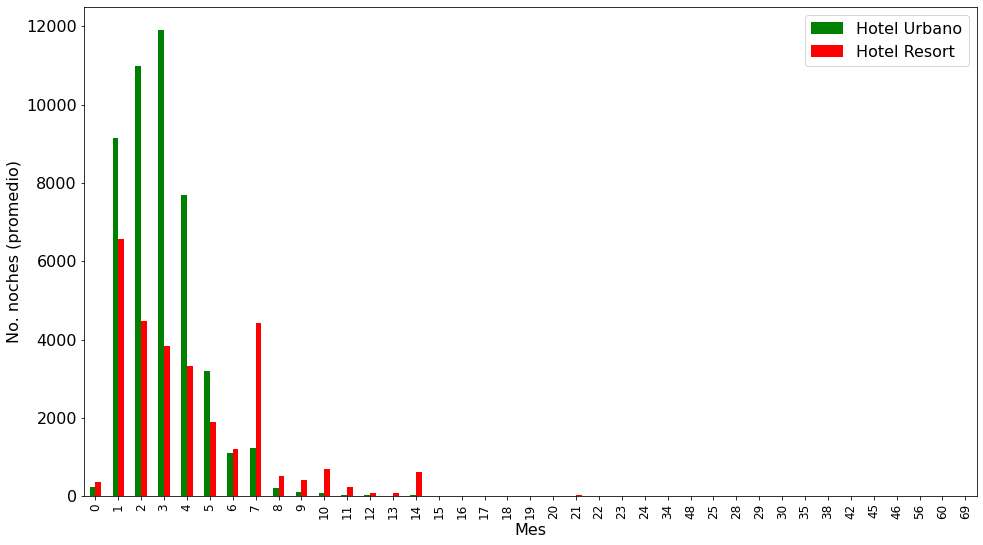

In [ ]:
# plot number of people per night
hotel_stays.plot.bar(linewidth=3.0, color=['green', 'red'], figsize=(16,9))

for t in plt.xticks()[1]:
    t.set_fontsize(12)

for t in plt.yticks()[1]:
    t.set_fontsize(16)

plt.xlabel('Month', fontsize=16)
plt.ylabel('No. Nights (average)',  fontsize=16)
plt.legend(fontsize=16)

For the city hotel we can observe that most people stay between 1 and 4 nights, with longer stays being less frequent. The maximum length of stay that can be seen is 12 nights, but these are quite unusual stays.

For the resort hotel we observe that most people stay either 1 night or 7 nights (one week), followed by 2 to 4 nights. Likewise, we see that a smaller number (although more significant than for the urban case) of guests booked stays of 10 to 14 days. This is to be expected if we consider that people who stay in this type of hotel usually do so for vacation purposes.

**Reservations by market segment**

We now consider the number of bookings (not cancelled) but by market segment. Since no periodicity is specified, we start by considering bookings per market segment and per average hotel per year.

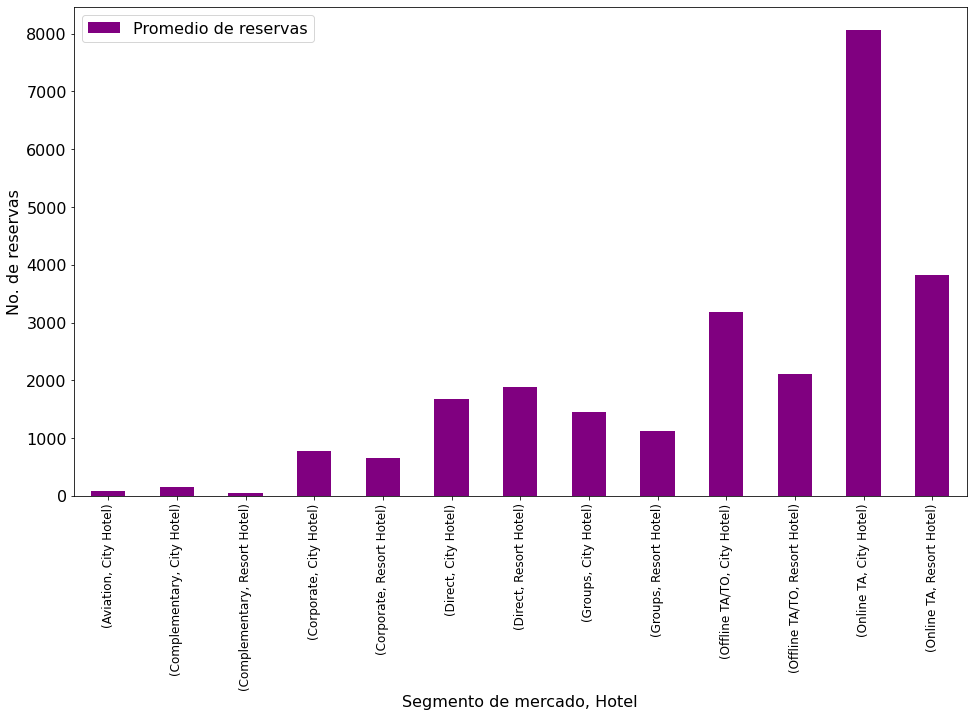

In [ ]:
# total reservations by market segment and hotel type
market_total = (df[df['is_canceled'] == 0].groupby(['market_segment', 'hotel'])['arrival_date_year'].
                value_counts().groupby(['market_segment','hotel']).mean()).to_frame()
market_total.columns = ['Average Reservations']
market_total.index.names = ['Market Segment', 'Hotel Type']

# graficas reservas totales por segmento de mercado
market_total.plot.bar(linewidth=3.0, figsize=(16,9), color='purple')

for t in plt.xticks()[1]: # cambiar tamaño de ticks horizontales
    t.set_fontsize(12)

for t in plt.yticks()[1]: # cambiar tamaño de ticks verticales
    t.set_fontsize(16)

plt.xlabel('Market segment, Hotel', fontsize=16)
plt.ylabel('No. of reservations',  fontsize=16)
plt.legend(fontsize=16)

Considering the average number of bookings per year per hotel and per market sector, we can observe that for both the urban hotel and the resort, most of the bookings have been made through an agency/platform through the internet (online). This is particularly significant for the city hotel, and in general is expected due to the great extension of digital platforms for hotel search and booking.

On the other hand, the lowest number of bookings correspond to the aviation and complementary sectors. Note that there are no reservations in resort hotels for the aviation sector, which makes sense as this corresponds to aviation personnel who usually only come to stay in a city hotel.

**How many reservations were cancelled?**

We count the number of cancelled reservations, by type of hotel and by each year. Since we do not have all the months for the three years it is not convenient to make an average in this part, so we better consider the total number of cancellations in the whole history of reservations provided.

In [ ]:
# total number of reservations cancelled (city hotel)
total_cancel_urban = df[df['is_canceled'] == 1][df['hotel'] == 'City Hotel']['id'].count()
print('Total of Cancellations (City Hotel): ', total_cancel_urban, ' (', round(total_cancel_urban/df.shape[0]*100,1), '%)')

# total number of reservations cancelled (resort hotel)
total_cancel_resort = df[df['is_canceled'] == 1][df['hotel'] == 'Resort Hotel']['id'].count()
print('Total of Cancellations (Resort Hotel): ', total_cancel_resort, ' (', round(total_cancel_resort/df.shape[0]*100,1), '%)')

Total de cancelaciones (hotel urbano):  33079  ( 27.7 %)
Total de cancelaciones (hotel resort):  11120  ( 9.3 %)


Considering the total data provided, we see that for the urban hotel we have a cancellation rate of 27.7% (33,079 cancellations), which corresponds to around 1 out of every 5 reservations having been cancelled. This percentage is lower for the resort hotel, with a total cancellation rate of 9.3% (11,120 cancellations), that is, around 1 out of every 10 reservations were cancelled.

We note then that the urban hotel has a proportion of cancelled reservations almost 3 times higher than the resort hotel. This can be explained by the fact that the resort hotel is usually booked by people during their holidays, and thus are less likely to change their plans as much as people who may just be looking for a city hotel to stay a few nights.

**Which month has the highest number of cancellations?**

We now consider the average number of cancellations per month and per hotel, and obtain the months with the highest cancellation rate.

In [ ]:
# monthly cancellations for city hotel
urban_cancel = (round(df[df['is_canceled'] == 1][df['hotel'] == 'City Hotel'].groupby('arrival_date_month')['arrival_date_year'].
              value_counts().groupby('arrival_date_month').mean(),1)).to_frame()

# sort by month
urban_cancel['Mes'] = pd.to_datetime(urban_cancel.index, format='%B').month
urban_cancel = urban_cancel.sort_values(by='Mes').drop('Mes',axis=1)
urban_cancel.index = months_esp
urban_cancel.index.names = ['Mes']

# monthly cancellations for resort hotel
resort_cancel = (round(df[df['is_canceled'] == 1][df['hotel'] == 'Resort Hotel'].groupby('arrival_date_month')['arrival_date_year'].
              value_counts().groupby('arrival_date_month').mean(),1)).to_frame()

# sort by month
resort_cancel['Mes'] = pd.to_datetime(resort_cancel.index, format='%B').month
resort_cancel = resort_cancel.sort_values(by='Mes').drop('Mes',axis=1)
resort_cancel.index = months_esp
resort_cancel.index.names = ['Mes']

# combine dataframes
monthly_cancel = urban_cancel.merge(resort_cancel, on='Mes')
monthly_cancel.columns = ['Cancellations (City Hotel)', 'Cancellations (Resort Hotel)']
monthly_cancel

,Cancelaciones (Hotel Urbano),Cancelaciones (Hotel Resort)
Mes,,
Enero,740.5,162.5
Febrero,949.5,397.0
Marzo,1192.5,381.5
Abril,1729.5,529.5
Mayo,1826.5,512.0
Junio,1763.5,503.5
Julio,1100.3,478.7
Agosto,1200.0,545.7
Septiembre,1554.5,503.0


In [ ]:
# month with the highest (average) number of cancellations (city hotel)
max_urban = monthly_cancel.index[monthly_cancel['Cancellations (City Hotel)'] == max(monthly_cancel['Cancellations (City Hotel)'])][0]
print('Month with the highest no. of cancellations (City Hotel): ', max_urban)

# month with the highest (average) number of cancellations (resort hotel)
max_resort = monthly_cancel.index[monthly_cancel['Cancellations (Resort Hotel)'] == max(monthly_cancel['Cancellations (Resort Hotel)'])][0]
print('Month with the highest no. of cancellations (Resort Hotel): ', max_resort)

Mes con mayor no. de cancelaciones (Hotel urbano):  Mayo
Mes con mayor no. de cancelaciones (Hotel resort):  Agosto


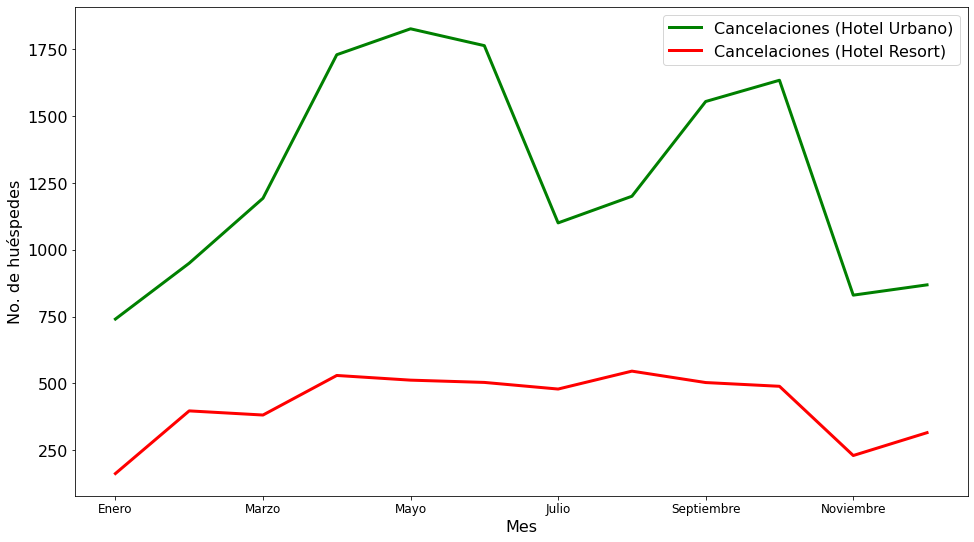

In [ ]:
# plot no. of guests per hotel
monthly_cancel.plot.line(linewidth=3.0, color=['green', 'red'], figsize=(16,9))

for t in plt.xticks()[1]:
    t.set_fontsize(12)

for t in plt.yticks()[1]:
    t.set_fontsize(16)

plt.xlabel('Month', fontsize=16)
plt.ylabel('No. of guests',  fontsize=16)
plt.legend(fontsize=16)

For the city hotel we observe that the highest number of cancellations (average) occurred between the months of April and June and between September and October. May is the month with the highest number of cancellations for this hotel.

For the resort hotel, we observe that the highest number of cancellations (average) is between April and October. August is the month with the highest number of cancellations for this hotel.

## III. Predictive Modeling - Preprocessing

We will now proceed to the prediction section. The objective is to predict whether a reservation will be cancelled based on past cancellations, i.e. to predict whether the value of the 'is_canceled' column will be 1 or 0. Therefore, we have a binary classification problem, and we will consider three different models to perform such prediction and compare their performances.

Before proceeding to the construction of the architectures, it is necessary to prepare the data and perform the selection of relevant features for the prediction of our target feature.

In [ ]:
# drop columns added during EDA
df.drop('level_0', axis=1, inplace=True)
df.drop('stays_nights', axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)

df.head(5)

,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,1,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0,Transient,0.0,0,0,Check-Out,1/7/2015
1,2,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0,Transient,0.0,0,0,Check-Out,1/7/2015
2,3,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0,Transient,75.0,0,0,Check-Out,2/7/2015
3,4,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2/7/2015
4,5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,3/7/2015


In [ ]:
# make a copy of the dataframe
data = df.copy()

**Outlier processing**

As we saw at the beginning of the notebook, there are extreme values in the dataset that could affect the performance of our predictive model.

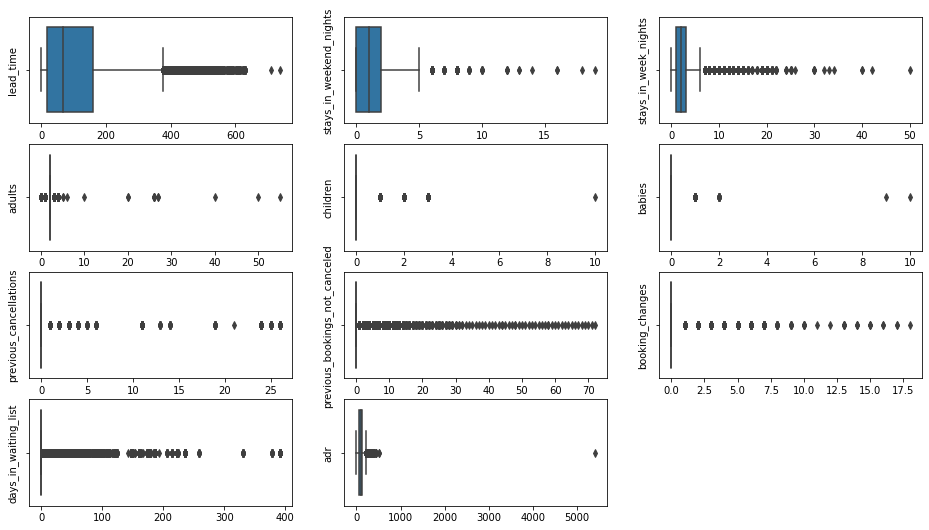

In [ ]:
# list of columns with potential outliers
out_cols = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults',
            'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
            'booking_changes', 'days_in_waiting_list', 'adr']

plt.figure(figsize=(16,9))

# plot boxplots in groups
for i, col in enumerate(out_cols):
  plt.subplot(4,3,i+1)
  sns.boxplot(df[col])
  plt.xlabel('')
  plt.ylabel(col)

In [ ]:
# percentage of outliers
for col in out_cols:
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  print(col, ':', round(((df[col] > (q3+1.5*iqr))).sum() / df.shape[0]*100,1), '%')

lead_time : 2.5 %
stays_in_weekend_nights : 0.2 %
stays_in_week_nights : 2.8 %
adults : 5.3 %
children : 7.2 %
babies : 0.8 %
previous_cancellations : 5.4 %
previous_bookings_not_canceled : 3.0 %
booking_changes : 15.1 %
days_in_waiting_list : 3.1 %
adr : 3.2 %


With the exception of 'booking_changes' most of the columns have a small percentage of extreme values (5% or less). However, in order not to have to completely remove the columns where they appear, we can treat such extreme values by using conditional expressions (we choose the limit values with the help of boxplots).

In [ ]:
# limitación de valores extremos
data.loc[data['lead_time'] > 600, 'lead_time'] = 600
data.loc[data['stays_in_weekend_nights'] > 7, 'stays_in_weekend_nights'] = 7
data.loc[data['stays_in_week_nights'] > 10, 'stays_in_week_nights'] = 10
data.loc[data['adults'] > 5, 'adults'] = 5
data.loc[data['children'] > 3, 'children'] = 3
data.loc[data['babies'] > 2, 'babies'] = 2
data.loc[data['previous_cancellations'] > 5, 'previous_cancellations'] = 5
data.loc[data['previous_bookings_not_canceled'] > 0, 'previous_bookings_not_canceled'] = 1
data.loc[data['booking_changes'] > 5, 'booking_changes'] = 5
data.loc[data['days_in_waiting_list'] > 100, 'days_in_waiting_list'] = 100
data.loc[data['adr'] > 1000, 'adr'] = 1000

**Data leakage**

One of the most common errors in modeling is to try to consider as model input, data that will not necessarily be available at the time the model is in production.

In [ ]:
# possible reservation states
data.reservation_status.unique()

By analyzing the columns available in the dataset, we see that the only column that can cause such information leakage would be the reservation status ('reservation_status'). Looking at the values that this column can have ('Check-Out', 'Canceled', 'No-Show'), it is evident that the reservation status almost always implies a-posteriori knowledge that the customer has canceled or not, when that is what we want to predict in the first place. Therefore, we remove that column from the input data.

In [ ]:
data.drop('reservation_status', axis=1, inplace=True)
data.head(5)

,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,1,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0,Transient,0.0,0,0,1/7/2015
1,2,Resort Hotel,0,600,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0,Transient,0.0,0,0,1/7/2015
2,3,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0,Transient,75.0,0,0,2/7/2015
3,4,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,2/7/2015
4,5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,3/7/2015


**Timestamp separation**

The 'reservation_status_date' column is a date that cannot be processed in that status. Therefore, we must first convert it to a timestamp and then separate it into its components.

In [ ]:
# convert column to Timestamp type
data['reservation_status_date'] = pd.to_datetime(data['reservation_status_date'])

# separate year, month, and day
data['reservation_status_date_year'] = data['reservation_status_date'].dt.year
data['reservation_status_date_month'] = data['reservation_status_date'].dt.month
data['reservation_status_date_day'] = data['reservation_status_date'].dt.day

# drop original column
data.drop('reservation_status_date', axis=1, inplace=True)

data.head(3)

,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date_year,reservation_status_date_month,reservation_status_date_day
0,1,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0,Transient,0.0,0,0,2015,1,7
1,2,Resort Hotel,0,600,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0,Transient,0.0,0,0,2015,1,7
2,3,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0,Transient,75.0,0,0,2015,2,7


**Encoding of categorical variables**

In order to be able to analyze the correlation of variables, it is necessary to encode the categorical variables into numerical variables. We start by identifying the columns with categorical variables.

In [ ]:
# columns with categorical variables
cat_cols = list(data.columns[data.dtypes == 'O'])
cat_cols

In [ ]:
# identify unique values in each column
for c in cat_cols:
  uni_cols = data[c].unique()
  print(c, '(', len(uni_cols), ') : ', uni_cols)

hotel ( 2 ) :  ['Resort Hotel' 'City Hotel']
arrival_date_month ( 12 ) :  ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
meal ( 5 ) :  ['BB' 'FB' 'HB' 'SC' 'Undefined']
country ( 178 ) :  ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' 'UNKNOWN' 'ROU' 'NOR' 'OMN' 'ARG'
 'POL' 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS'
 'EST' 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX'
 'MAR' 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF'
 'AGO' 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN'
 'JAM' 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL'
 'GGY' 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL'
 'SEN' 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA'
 'CUB' 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP'
 'BDI' 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL'
 'UZB' 'NPL' 'BHS' 

To transform categorical variables it is necessary to consider different encoding methods.

When we have a clear hierarchy in the variables (as in the case of months or type of room), it is convenient to apply *label encoding*. Likewise, this can be applied when we have categorical variables with high cardinality (as in the case of countries).

When we do not have a hierarchy between variables and/or we have low cardinality, it is convenient to apply *one-hot encoding*. However, in this case we have to be careful with the *dummy variable trap*, since it may happen that the new columns present a high collinearity between them. To avoid this, we minimize the number of new columns created.

It is important to mention that encoding is usually performed **after training and validation sets**. Here we only perform it to study the correlations and choose the features that work best to predict the model, and we will repeat it once the separation of variables is done.

In [ ]:
data2 = data.copy()

# define categorical encoders
lbl_enc = LabelEncoder()
hot_enc = OneHotEncoder(drop='first', sparse=False)

row_size = data2.shape[0]

# one-hot encoding for 'hotel'
col_name = 'hotel'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(hot_enc.fit_transform(col_1), (row_size))
col_df = pd.DataFrame(col_2, columns = [col_name+'_type'])
data2 = pd.concat([data2, col_df], axis=1)
data2.drop(col_name, axis=1, inplace=True)

# label encoding for 'arrival_date_month'
col_name = 'arrival_date_month'
data2[col_name] = data2[col_name].map({'January': 0, 'February': 1,
                                       'March': 2, 'April': 3, 'May': 4,
                                       'June': 5, 'July': 6, 'August': 7,
                                       'September': 8, 'October': 9,
                                       'November': 10, 'December': 11})

# label encoding for 'meal'
col_name = 'meal'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# label encoding 'country'
col_name = 'country'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# label encoding 'market_segment'
col_name = 'market_segment'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# label encoding 'distribution_channel'
col_name = 'distribution_channel'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# label encoding 'reserved_room_type'
col_name = 'reserved_room_type'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# label encoding 'assigned_room_type'
col_name = 'assigned_room_type'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# label encoding 'deposit_type'
col_name = 'deposit_type'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# label encoding 'customer_type'
col_name = 'customer_type'
col_1 = np.reshape(np.asarray(data2[col_name]), (row_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (row_size))
data2[col_name] = col_2

# label encoding'arrival_date_year'
col_name = 'arrival_date_year'
data2[col_name] = data2[col_name].map({2015: 0, 2016: 1, 2017: 2})

# label encoding 'reservation_status_date_year'
col_name = 'reservation_status_date_year'
data2[col_name] = data2[col_name].map({2015: 0, 2016: 1, 2017: 2})

data2.head(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date_year,reservation_status_date_month,reservation_status_date_day,hotel_type
0,1,0,342,0,6,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,3,0,0.0,0,2,0.0,0,0,0.0,1,7,1.0
1,2,0,600,0,6,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,4,0,0.0,0,2,0.0,0,0,0.0,1,7,1.0
2,3,0,7,0,6,27,1,0,1,1,0.0,0,0,59,3,1,0,0,0,0,2,0,0,0.0,0,2,75.0,0,0,0.0,2,7,1.0
3,4,0,13,0,6,27,1,0,1,1,0.0,0,0,59,2,0,0,0,0,0,0,0,0,304.0,0,2,75.0,0,0,0.0,2,7,1.0
4,5,0,14,0,6,27,1,0,2,2,0.0,0,0,59,6,3,0,0,0,0,0,0,0,240.0,0,2,98.0,0,1,0.0,3,7,1.0


**Variable correlation**

Taking into account that the column to be predicted is 'is_canceled', we will analyze which variables have the highest correlation coefficients with this characteristic in order to do feature selection.

In [ ]:
# drop 'id' column since its just a row index
data2.drop('id', axis=1, inplace=True)

# calculate correlation matrix
corr_matrix = data2.corr()

# get correlations with respect to target feature
corr_cancel = corr_matrix['is_canceled'].abs().sort_values(ascending=False)
corr_cancel

is_canceled                       1.000000
deposit_type                      0.468676
lead_time                         0.292935
country                           0.265194
id                                0.241737
total_of_special_requests         0.234877
previous_cancellations            0.204821
required_car_parking_spaces       0.195701
assigned_room_type                0.175843
distribution_channel              0.167707
booking_changes                   0.152321
hotel_type                        0.137082
previous_bookings_not_canceled    0.115446
reservation_status_date_year      0.112199
is_repeated_guest                 0.083745
days_in_waiting_list              0.069899
customer_type                     0.068206
reserved_room_type                0.062216
adults                            0.061882
market_segment                    0.059419
adr                               0.047735
agent                             0.046770
reservation_status_date_month     0.045398
reservation

In [ ]:
# get list of variables with the highest correlations
list((corr_cancel[(corr_cancel.index != 'is_canceled') & (corr_cancel > 0.1)]).index)

['deposit_type',
 'lead_time',
 'country',
 'id',
 'total_of_special_requests',
 'previous_cancellations',
 'required_car_parking_spaces',
 'assigned_room_type',
 'distribution_channel',
 'booking_changes',
 'hotel_type',
 'previous_bookings_not_canceled',
 'reservation_status_date_year']

We consider variables with a correlation of more than 10%, and extract a total of 12 characteristics that are likely to be the best predictors of our model. We include price even though it does not appear because it is reasonable to assume that it influences the cancellation rate.

In [ ]:
# save a list with features used for modeling
features = ['deposit_type', 'lead_time', 'country', 'total_of_special_requests',
            'previous_cancellations', 'required_car_parking_spaces',
            'assigned_room_type', 'distribution_channel', 'booking_changes',
            'hotel', 'previous_bookings_not_canceled', 'reservation_status_date_year', 'adr']

target = 'is_canceled'

**Data set separation**

Once the variables to be used in our models have been chosen, it is necessary to start by separating the data into a training set and a validation set. We follow the standard methodology where 70% of the original set will be for training, and 30% will be for validation.

In [ ]:
# separe features and target dataframes
X = data[features]
y = data[target]

# train test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

**Categorical variable codification (post-splitting)**

We now proceed to perform the coding of categorical variables separately for the training and validation sets.

In [ ]:
# define categorical encoders
lbl_enc = LabelEncoder()
hot_enc = OneHotEncoder(drop='first', sparse=False)

In [ ]:
# TOTAL SET (for cross-validation)
X.reset_index(inplace=True)
X.drop('index', axis=1, inplace=True)

total_size = X.shape[0]

# encoding for 'hotel' (label)
col_name = 'hotel'
col_1 = np.reshape(np.asarray(X[col_name]), (total_size, 1))
col_2 = np.reshape(hot_enc.fit_transform(col_1), (total_size))
col_df = pd.DataFrame(col_2, columns = [col_name+'_type'])
X = pd.concat([X, col_df], axis=1)
X.drop(col_name, axis=1, inplace=True)

# encoding for  'distribution_channel' (label)
col_name = 'distribution_channel'
col_1 = np.reshape(np.asarray(X[col_name]), (total_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (total_size))
X[col_name] = col_2

# encoding for  'country' (label)
col_name = 'country'
col_1 = np.reshape(np.asarray(X[col_name]), (total_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (total_size))
X[col_name] = col_2

# encoding for  'deposit_type' (label)
col_name = 'deposit_type'
col_1 = np.reshape(np.asarray(X[col_name]), (total_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (total_size))
X[col_name] = col_2

# encoding for  'assigned_room_type' (label)
col_name = 'assigned_room_type'
col_1 = np.reshape(np.asarray(X[col_name]), (total_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (total_size))
X[col_name] = col_2

# encoding for  'reservation_status_date_year' (label)
col_name = 'reservation_status_date_year'
X[col_name] = X[col_name].map({2014: 0, 2015: 1, 2016: 2, 2017: 3})

X.head(5)

,deposit_type,lead_time,country,total_of_special_requests,previous_cancellations,required_car_parking_spaces,assigned_room_type,distribution_channel,booking_changes,previous_bookings_not_canceled,reservation_status_date_year,adr,hotel_type
0,0,342,135,0,0,0,2,1,3,0,1,0.0,1.0
1,0,600,135,0,0,0,2,1,4,0,1,0.0,1.0
2,0,7,59,0,0,0,2,1,0,0,1,75.0,1.0
3,0,13,59,0,0,0,0,0,0,0,1,75.0,1.0
4,0,14,59,1,0,0,0,3,0,0,1,98.0,1.0


In [ ]:
# TRAINING SET
X_train.reset_index(inplace=True)
X_train.drop('index', axis=1, inplace=True)

train_size = X_train.shape[0]

# encoding for  'hotel' (label)
col_name = 'hotel'
col_1 = np.reshape(np.asarray(X_train[col_name]), (train_size, 1))
col_2 = np.reshape(hot_enc.fit_transform(col_1), (train_size))
col_df = pd.DataFrame(col_2, columns = [col_name+'_type'])
X_train = pd.concat([X_train, col_df], axis=1)
X_train.drop(col_name, axis=1, inplace=True)

# encoding for  'distribution_channel' (label)
col_name = 'distribution_channel'
col_1 = np.reshape(np.asarray(X_train[col_name]), (train_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (train_size))
X_train[col_name] = col_2

# encoding for  'country' (label)
col_name = 'country'
col_1 = np.reshape(np.asarray(X_train[col_name]), (train_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (train_size))
X_train[col_name] = col_2

# encoding for  'deposit_type' (label)
col_name = 'deposit_type'
col_1 = np.reshape(np.asarray(X_train[col_name]), (train_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (train_size))
X_train[col_name] = col_2

# encoding for  'assigned_room_type' (label)
col_name = 'assigned_room_type'
col_1 = np.reshape(np.asarray(X_train[col_name]), (train_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (train_size))
X_train[col_name] = col_2

# encoding for 'reservation_status_date_year' (label)
col_name = 'reservation_status_date_year'
X_train[col_name] = X_train[col_name].map({2014: 0, 2015: 1, 2016: 2, 2017: 3})


X_train.head(5)

,deposit_type,lead_time,country,total_of_special_requests,previous_cancellations,required_car_parking_spaces,assigned_room_type,distribution_channel,booking_changes,previous_bookings_not_canceled,reservation_status_date_year,adr,hotel_type
0,0,29,58,0,0,0,0,3,0,0,2,132.05,0.0
1,0,0,128,0,0,0,3,1,0,0,2,51.00,1.0
2,0,25,50,2,0,0,5,3,2,0,1,201.05,1.0
3,0,98,128,1,0,0,0,3,0,0,3,68.00,0.0
4,0,72,128,0,0,0,3,1,0,0,2,73.33,1.0


In [ ]:
# VALIDATION SET
X_test.reset_index(inplace=True)
X_test.drop('index', axis=1, inplace=True)

test_size = X_test.shape[0]

# encoding for 'hotel' (one-hot)
col_name = 'hotel'
col_1 = np.reshape(np.asarray(X_test[col_name]), (test_size, 1))
col_2 = np.reshape(hot_enc.fit_transform(col_1), (test_size))
col_df = pd.DataFrame(col_2, columns = [col_name+'_type'])
X_test = pd.concat([X_test, col_df], axis=1)
X_test.drop(col_name, axis=1, inplace=True)

# encoding for 'distribution_channel' (one-hot)
col_name = 'distribution_channel'
col_1 = np.reshape(np.asarray(X_test[col_name]), (test_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (test_size))
X_test[col_name] = col_2

# encoding for 'country' (label)
col_name = 'country'
col_1 = np.reshape(np.asarray(X_test[col_name]), (test_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (test_size))
X_test[col_name] = col_2

# encoding for 'deposit_type' (one-hot)
col_name = 'deposit_type'
col_1 = np.reshape(np.asarray(X_test[col_name]), (test_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (test_size))
X_test[col_name] = col_2

# encoding for 'assigned_room_type' (label)
col_name = 'assigned_room_type'
col_1 = np.reshape(np.asarray(X_test[col_name]), (test_size, 1))
col_2 = np.reshape(lbl_enc.fit_transform(col_1), (test_size))
X_test[col_name] = col_2

# encoding for 'reservation_status_date_year' (label)
col_name = 'reservation_status_date_year'
X_test[col_name] = X_test[col_name].map({2014: 0, 2015: 1, 2016: 2, 2017: 3})


X_test.head(5)

,deposit_type,lead_time,country,total_of_special_requests,previous_cancellations,required_car_parking_spaces,assigned_room_type,distribution_channel,booking_changes,previous_bookings_not_canceled,reservation_status_date_year,adr,hotel_type
0,0,190,54,0,0,0,0,3,0,0,2,96.3,0.0
1,0,80,135,0,0,0,0,3,0,0,3,126.0,0.0
2,0,33,41,1,0,0,0,3,0,0,2,135.9,0.0
3,0,7,128,0,0,0,0,2,0,0,2,97.0,0.0
4,0,1,133,0,0,0,0,0,1,0,1,35.0,1.0


**Renormalization**

Since we have a large range of numerical variables, we renormalize the training and validation sets separately. This will help to improve the performance of the models.

In [ ]:
# numerical columns
num_cols = ['lead_time', 'total_of_special_requests', 'previous_cancellations',
            'required_car_parking_spaces', 'booking_changes', 'previous_bookings_not_canceled', 'adr']

for col in num_cols:
  print(col, max(X_train[col]))

lead_time 600
total_of_special_requests 5
previous_cancellations 5
required_car_parking_spaces 8
booking_changes 5
previous_bookings_not_canceled 1
adr 1000.0


In [ ]:
# TOTAL SET

# standarization for 'lead_time
col_name = 'lead_time'
X[col_name] = np.log(X[col_name]+1)

# standarization for 'adr
col_name = 'adr'
X[col_name] = np.log(X[col_name]+1)
X[col_name] = X[col_name].fillna(value=X[col_name].mean())

X.head(3)

,deposit_type,lead_time,country,total_of_special_requests,previous_cancellations,required_car_parking_spaces,assigned_room_type,distribution_channel,booking_changes,previous_bookings_not_canceled,reservation_status_date_year,adr,hotel_type
0,0,5.837730,135,0,0,0,2,1,3,0,1,0.000000,1.0
1,0,6.398595,135,0,0,0,2,1,4,0,1,0.000000,1.0
2,0,2.079442,59,0,0,0,2,1,0,0,1,4.330733,1.0


In [ ]:
# TRAINING SET

# standarization for 'lead_time
col_name = 'lead_time'
X_train[col_name] = np.log(X[col_name]+1)

# standarization for 'adr
col_name = 'adr'
X_train[col_name] = np.log(X[col_name]+1)
X_train[col_name] = X_train[col_name].fillna(value=X_train[col_name].mean())

X_train.head(3)

,deposit_type,lead_time,country,total_of_special_requests,previous_cancellations,required_car_parking_spaces,assigned_room_type,distribution_channel,booking_changes,previous_bookings_not_canceled,reservation_status_date_year,adr,hotel_type
0,0,1.922456,58,0,0,0,0,3,0,0,2,0.000000,0.0
1,0,2.001290,128,0,0,0,3,1,0,0,2,0.000000,1.0
2,0,1.124748,50,2,0,0,5,3,2,0,1,1.673489,1.0


In [ ]:
# VALIDATION SET

# standarization for 'lead_time
col_name = 'lead_time'
X_test[col_name] = np.log(X[col_name]+1)

# standarization for 'adr
col_name = 'adr'
X_test[col_name] = np.log(X[col_name]+1)
X_test[col_name] = X_test[col_name].fillna(value=X_test[col_name].mean())

X_test.head(3)

,deposit_type,lead_time,country,total_of_special_requests,previous_cancellations,required_car_parking_spaces,assigned_room_type,distribution_channel,booking_changes,previous_bookings_not_canceled,reservation_status_date_year,adr,hotel_type
0,0,1.922456,54,0,0,0,0,3,0,0,2,0.000000,0.0
1,0,2.001290,135,0,0,0,0,3,0,0,3,0.000000,0.0
2,0,1.124748,41,1,0,0,0,3,0,0,2,1.673489,0.0


We now proceed to perform the predictions with three models. We calculate both the cross-validation score as well as additional metrics to compare model performance.

## Predictive Model (Logistic Regression)

In [ ]:
# define and train model
lgr = LogisticRegression()
lgr.fit(X_train, y_train)

# predict with model
lgr_pred = lgr.predict(X_test)

# confusion matrix
conf_matrix = confusion_matrix(y_test, lgr_pred)
print('CONFUSION MATRIX')
print(conf_matrix)

# validation metrics
accuracy = accuracy_score(y_test, lgr_pred)
print('ACCURACY')
print(round(accuracy,4))

f1 = f1_score(y_test, lgr_pred)
print('F1 SCORE')
print(round(f1,4))

MATRIX DE CONFUSION
[[22320   194]
 [ 8228  5021]]
PRECISIÓN
0.7645
MÉTRICA F1
0.5439


In [ ]:
val_score = cross_val_score(lgr, X_train, y_train, cv=4)
print('CROSS-VALIDATION SCORE (K-FOLD = 4)')
print(round(np.mean(val_score),4))

PUNTAJE DE VALIDACIÓN CRUZADA (K-FOLD = 4)
0.7695


## Predictive Model (XG Boost)

In [ ]:
# define and train model
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# predict with model
xgb_pred = xgb.predict(X_test)

# confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_pred)
print('CONFUSION MATRIX')
print(conf_matrix)

# validation metrics
accuracy = accuracy_score(y_test, xgb_pred)
print('ACCURACY')
print(round(accuracy,4))

f1 = f1_score(y_test, xgb_pred)
print('F1 SCORE')
print(round(f1,4))

MATRIX DE CONFUSION
[[21762   752]
 [ 7459  5790]]
PRECISIÓN
0.7704
MÉTRICA F1
0.5851


In [ ]:
val_score = cross_val_score(xgb, X_train, y_train, cv=4)
print('CROSS-VALIDATION SCORE (K-FOLD = 4)')
print(round(np.mean(val_score),4))

PUNTAJE DE VALIDACIÓN CRUZADA (K-FOLD = 4)
0.7974


## Predictive Model (neural networks)

In [ ]:
# define metrics for NN

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# define target for binary classifcation
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# define DNN model
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

# compile neural network
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[precision_m, recall_m, f1_m])

# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
2608/2608 [==============================] - 11s 4ms/step - loss: 0.5533 - precision_m: 0.7267 - recall_m: 0.7302 - f1_m: 0.7249 - val_loss: 0.4758 - val_precision_m: 0.7671 - val_recall_m: 0.7645 - val_f1_m: 0.7658
Epoch 2/10
2608/2608 [==============================] - 10s 4ms/step - loss: 0.4678 - precision_m: 0.7673 - recall_m: 0.7647 - f1_m: 0.7641 - val_loss: 0.4599 - val_precision_m: 0.7684 - val_recall_m: 0.7658 - val_f1_m: 0.7671
Epoch 3/10
2608/2608 [==============================] - 10s 4ms/step - loss: 0.4531 - precision_m: 0.7745 - recall_m: 0.7724 - f1_m: 0.7732 - val_loss: 0.4593 - val_precision_m: 0.7675 - val_recall_m: 0.7673 - val_f1_m: 0.7674
Epoch 4/10
2608/2608 [==============================] - 10s 4ms/step - loss: 0.4433 - precision_m: 0.7751 - recall_m: 0.7749 - f1_m: 0.7749 - val_loss: 0.4477 - val_precision_m: 0.7774 - val_recall_m: 0.7814 - val_f1_m: 0.7794
Epoch 5/10
2608/2608 [==============================] - 10s 4ms/step - loss: 0.4331 - precis

In [ ]:
# validation metrics
accuracy = history.history['precision_m'][-1]
print('ACCURACY')
print(round(accuracy,4))

f1 = history.history['f1_m'][-1]
print('F1 SCORE')
print(round(f1,4))

PRECISIÓN
0.7857
MÉTRICA F1
0.7864


In [ ]:
# define target as binary classifcation
y = to_categorical(y)

# perform cross-validation
k = 4
num_val_samples = len(X) // k
num_epochs = 10
all_scores = []

for i in range(k):
  print('K-fold: ', i)

  # generate validation set
  val_data = X[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = y[i * num_val_samples: (i + 1) * num_val_samples]

  # generate training set
  train_data = np.concatenate(
        [X[:i * num_val_samples],
         X[(i + 1) * num_val_samples:]],
        axis=0)
  train_targets = np.concatenate(
        [y[:i * num_val_samples],
         y[(i + 1) * num_val_samples:]],
        axis=0)

  # train model
  history = model.fit(train_data, train_targets, validation_data=(val_data, val_targets), epochs=num_epochs)

  # save validation emtrics history
  all_scores.append(history.history['precision_m'][-1])

K-fold:  0
Epoch 1/10
2794/2794 [==============================] - 11s 4ms/step - loss: 0.3855 - precision_m: 0.8106 - recall_m: 0.8104 - f1_m: 0.8105 - val_loss: 1.4284 - val_precision_m: 0.6904 - val_recall_m: 0.6908 - val_f1_m: 0.6906
Epoch 2/10
2794/2794 [==============================] - 10s 4ms/step - loss: 0.3696 - precision_m: 0.8191 - recall_m: 0.8183 - f1_m: 0.8187 - val_loss: 1.8888 - val_precision_m: 0.6864 - val_recall_m: 0.6861 - val_f1_m: 0.6862
Epoch 3/10
2794/2794 [==============================] - 9s 3ms/step - loss: 0.3651 - precision_m: 0.8219 - recall_m: 0.8219 - f1_m: 0.8219 - val_loss: 1.7196 - val_precision_m: 0.6835 - val_recall_m: 0.6830 - val_f1_m: 0.6832
Epoch 4/10
2794/2794 [==============================] - 10s 4ms/step - loss: 0.3624 - precision_m: 0.8227 - recall_m: 0.8222 - f1_m: 0.8224 - val_loss: 2.3139 - val_precision_m: 0.6811 - val_recall_m: 0.6810 - val_f1_m: 0.6810
Epoch 5/10
2794/2794 [==============================] - 10s 3ms/step - loss: 0.358

In [ ]:
# cross-validation metric
val_score = np.mean(all_scores)
print('CROSS VALIDATION SCORE (K-FOLD = 4)')
print(round(val_score,4))

PUNTAJE DE VALIDACIÓN CRUZADA (K-FOLD = 4)
0.8497


## Conclusion

Of the three models implemented, we see that we obtain the best cross-validation metrics for the densely connected neural network (~85%). Obviously the disadvantage of this model lies in the extensive training time and computational capacity for training the layers. However, if a faster model is desired, the XGBoost Classifier could be applied, as it had a validation metric close to 80%. Several tests indicate that it is possible to increase the performance of this model with another parameter selection, parameter transformation, or even with the construction of a deeper neural network that can take all the parameters of the original dataset.